# Чекпоинт 3: Бейзлайн 1 (Faster RCNN)

## 0. Установка зависимостей и скачивание датасета (Stanford Cars Dataset)

In [ ]:
!pip install --quiet torch torchvision pycocotools

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import device as tdevice
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms as T
from torchvision.ops import box_iou
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.notebook import tqdm

In [ ]:
#Функции из baseline_utils.py

from baseline_utils import (
    map_to_general_category, load_and_process, 
    StanfordCarsDataset, collate_fn,
    train, evaluate_f1
)

In [ ]:
#Скачиваем датасет (images)

#1. Установим gdown
!pip install --quiet --upgrade gdown

#2. Скачаем zip по ID из Drive
!gdown 1x88IjoAE6CWQp0UqEDPX7i3KvWgADqJf -O /content/stanford_cars_dataset_rcnn.zip

#3. Распакуем архив
!unzip -q /content/stanford_cars_dataset_rcnn.zip -d /content/

#4. И удалим сам zip, чтобы оптимизировать место
!rm /content/stanford_cars_dataset_rcnn.zip

#Теперь вся папка будет доступна локально

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=13OKSjDCwitFk022HJJ1cugJyb-46dka5
From (redirected): https://drive.google.com/uc?id=13OKSjDCwitFk022HJJ1cugJyb-46dka5&confirm=t&uuid=021f9ec3-f704-4179-ac5c-1e70d87afa76
To: /content/stanford_cars_dataset.zip
100% 2.00G/2.00G [00:55<00:00, 36.2MB/s]


## 1. Сбор, подготовка данных, обобщение в меньшее кол-во классов (196 -> 9)

In [ ]:
#Пути к разметке для train и test (.csv файлы с подробной информацией об объектах)
train_labels_path = 'https://drive.google.com/uc?export=download&id=1Wh-NCRjBbONPL6kjs55jWvtyPdTwWdYi'
test_labels_path = 'https://drive.google.com/uc?export=download&id=1g0AQ8Gtku3EDjdCNqJLb3ewzJJoLZbOG'
#Пути к фото для train и test
train_images_path = os.path.join('/content/stanford_cars_dataset', 'train', 'images')
test_images_path  = os.path.join('/content/stanford_cars_dataset', 'test',  'images')

#Обобщение в категории
general_categories = {
    'Sedan': ['Sedan'],
    'SUV': ['SUV'],
    'Coupe': ['Coupe'],
    'Convertible': ['Convertible'],
    'Hatchback': ['Hatchback'],
    'Minivan': ['Minivan'],
    'Van': ['Van'],
    'Truck': ['Crew Cab', 'Extended Cab', 'Regular Cab'],
}

In [ ]:
train_labels = load_and_process(train_labels_path, general_categories)
test_labels  = load_and_process(test_labels_path, general_categories)

## 2. Обучение

In [ ]:
#Загрузка данных и создание DataLoader
train_set = StanfordCarsDataset('/content/stanford_cars_dataset/train', train_labels, transforms=T.ToTensor())
val_set  = StanfordCarsDataset('/content/stanford_cars_dataset/test',  test_labels,  transforms=T.ToTensor())

train_loader = DataLoader(train_set, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader  = DataLoader(val_set,  batch_size=4, shuffle=False, collate_fn=collate_fn)

### 2.1 Обучение head (3 эпохи)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 162MB/s]


Epoch 1/3:   0%|          | 0/2036 [00:00<?, ?it/s]

Epoch 1/3 finished, avg loss: 0.1057


Epoch 2/3:   0%|          | 0/2036 [00:00<?, ?it/s]

Epoch 2/3 finished, avg loss: 0.0787


Epoch 3/3:   0%|          | 0/2036 [00:00<?, ?it/s]

Epoch 3/3 finished, avg loss: 0.0722


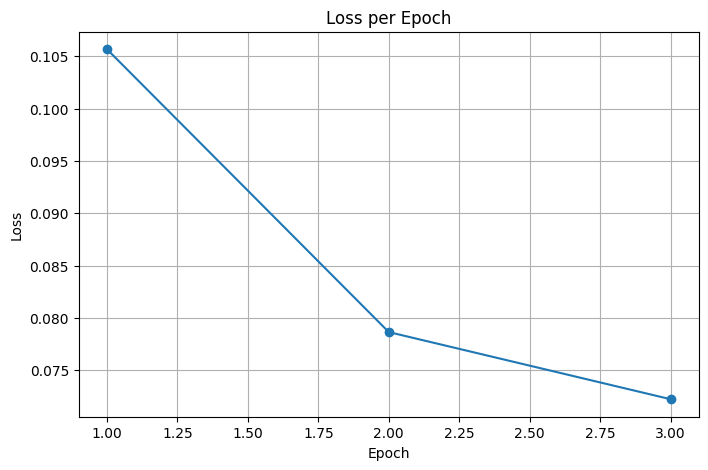

Epoch 1/7:   0%|          | 0/2036 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#1. Базовые параметры
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes  = 10                             # 9 объектов + background

#2. Загружаем COCO-веса и меняем классификационную голову
faster_rcnn_model = fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
in_features = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
faster_rcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
faster_rcnn_model.to(device)

#3. Замораживаем backbone → учим только голову
for p in faster_rcnn_model.backbone.body.parameters():
    p.requires_grad = False

#4. Оптимизатор (только trainable-параметры)
optimizer = SGD(
    filter(lambda p: p.requires_grad, faster_rcnn_model.parameters()),
    lr=5e-3, momentum=0.9, weight_decay=5e-4
)

#5. Тренируем 3 эпохи и сохраняем чекпойнт
train(faster_rcnn_model, train_loader, optimizer, device, num_epochs=3)

### 2.2 Обучаем полностью (3 эпохи)

In [ ]:
#1. Базовые параметры
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10

#2. Собираем ту же архитектуру (backbone ImageNet, своя голова)
faster_rcnn_model = fasterrcnn_resnet50_fpn(
    weights=None, pretrained_backbone=True, num_classes=num_classes
).to(device)

#3. Загружаем чекпойнт из этапа 1 (stage 1)
faster_rcnn_model.load_state_dict(torch.load("faster_rcnn_head.pt", map_location=device))

#4. Размораживаем ВСЕ параметры для fine-tune
for p in faster_rcnn_model.backbone.parameters():
    p.requires_grad = True

#5. Оптимизатор для всей сети
optimizer = SGD(
    faster_rcnn_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4
)

#6. Дообучаем ещё 3 эпохи и сохраняем промежуточный чекпойнт
train(faster_rcnn_model, train_loader, optimizer, device, num_epochs=3)

#Успело обучиться только на двух эпохах - закончились вычислительные ресурсы

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3:   0%|          | 0/2036 [00:00<?, ?it/s]

Epoch 1/3 finished, avg loss: 0.0652
Checkpoint saved to faster_rcnn_final.pt


Epoch 2/3:   0%|          | 0/2036 [00:00<?, ?it/s]

Epoch 2/3 finished, avg loss: 0.0593
Checkpoint saved to faster_rcnn_final.pt


Epoch 3/3:   0%|          | 0/2036 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#1. Базовые параметры
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes  = 10
extra_epochs = 2                                #сколько ещё доучить

#2. Воссоздаём точную архитектуру
faster_rcnn_model = fasterrcnn_resnet50_fpn(
    weights=None, pretrained_backbone=True, num_classes=num_classes
).to(device)

#3. Загружаем pre-final чекпойнт
faster_rcnn_model.load_state_dict(torch.load("faster_rcnn_prefinal.pt", map_location=device))

#4. Размораживаем backbone (всё обучение)
for p in faster_rcnn_model.backbone.parameters():
    p.requires_grad = True

#5. Оптимизатор для всех параметров
optimizer = SGD(
    faster_rcnn_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4
)

#6. Продолжаем обучение
train(faster_rcnn_model, train_loader, optimizer, device, num_epochs=extra_epochs)

Epoch 1/2:   0%|          | 0/2036 [00:00<?, ?it/s]

Epoch 1/2 finished, avg loss: 0.0561
Checkpoint saved to faster_rcnn_final.pt


Epoch 2/2:   0%|          | 0/2036 [00:00<?, ?it/s]

## 3. Оценка

In [ ]:
#1. Путь и устройство
ckpt_path = "faster_rcnn_final.pt"
device    = tdevice("cuda" if torch.cuda.is_available() else "cpu")

#2. Создаём ТОЧНО такую же архитектуру
num_classes = 10                       #9 объектов + background
faster_rcnn_model = fasterrcnn_resnet50_fpn(
    weights=None,                      #голову COCO не загружаем
    pretrained_backbone=True,          #backbone ImageNet — как при обучении
    num_classes=num_classes
).to(device)

#3. Загружаем веса
state_dict = torch.load(ckpt_path, map_location=device)
faster_rcnn_model.load_state_dict(state_dict)
faster_rcnn_model.eval()                          

#4. Оцениваем на валидации
prec, rec, f1 = evaluate_f1(faster_rcnn_model, val_loader, device, iou_thresh=0.5, score_thresh=0.05)
print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

<ipython-input-13-78b98a9aeb41>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=device)


Eval:   0%|          | 0/2011 [00:00<?, ?it/s]

Precision: 0.142, Recall: 0.573, F1: 0.228
